### Evaluator-Optimizer Pattern

The evaluator-optimizer pattern is a powerful workflow where one LLM generates content while another evaluates it. If the output doesn't meet quality criteria, the evaluator provides feedback and the generator creates an improved version. This loop continues until acceptable output is produced.

Common use cases:
- Content generation with quality gates (jokes, stories, code)
- Translation refinement across languages
- Response polishing based on specific criteria
- Iterative improvements with measurable success metrics

This pattern differs from simple prompt chaining because it includes conditional looping based on evaluation results.

## Setup and Dependencies

In [1]:
# Core imports
from typing_extensions import TypedDict, Literal
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

## Environment Configuration

Using Groq Cloud for fast inference and cost-effective LLM calls.

In [2]:
import os
from getpass import getpass

# Set API key for Groq
if "GROQ_API_KEY" not in os.environ:
    os.environ["GROQ_API_KEY"] = getpass("Enter your Groq API key: ")

## LLM Initialization

Initialize the Groq LLM with llama-3.3-70b for both generation and evaluation tasks.

In [3]:
from langchain_groq import ChatGroq

# Initialize LLM - using Groq for fast inference
llm = ChatGroq(
    model="llama-3.3-70b-versatile",
    temperature=0.7  # Higher temp for creative generation
)

/Users/yashsarode/Downloads/Personal Projects/Python/LangGraph-personal/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## State Definition

The graph state tracks the entire workflow lifecycle:
- Input topic
- Generated content
- Evaluation feedback
- Quality verdict

In [4]:
# Graph state definition
class State(TypedDict):
    topic: str              # Input: what to generate content about
    joke: str               # Generated content
    feedback: str           # Evaluator's improvement suggestions
    funny_or_not: str       # Evaluation verdict: "funny" or "not funny"

## Structured Output Schema

Define the evaluation response format using Pydantic for type safety and validation. The evaluator must return both a binary grade and actionable feedback.

In [5]:
# Structured output for evaluation results
class Feedback(BaseModel):
    grade: Literal["funny", "not funny"] = Field(
        description="Binary decision: is the joke funny or not?"
    )
    feedback: str = Field(
        description="Specific suggestions for improvement if not funny"
    )

## Augment LLM with Structured Output

Bind the Feedback schema to the LLM so it returns validated, structured responses instead of free-form text.

In [6]:
# Create evaluator with structured output
evaluator = llm.with_structured_output(Feedback)

## Node: Content Generator

The generator node creates content based on:
1. Initial topic (first iteration)
2. Topic + previous feedback (subsequent iterations)

This allows the LLM to learn from evaluation and improve output.

In [7]:
def llm_call_generator(state: State):
    """Generate content based on topic and optional feedback"""
    
    # Check if we have feedback from a previous iteration
    if state.get("feedback"):
        # Incorporate feedback into generation prompt
        prompt = (
            f"Write a joke about {state['topic']}. "
            f"Previous attempt was rejected with this feedback: {state['feedback']}"
        )
    else:
        # First attempt - generate from topic only
        prompt = f"Write a clever joke about {state['topic']}"
    
    msg = llm.invoke(prompt)
    return {"joke": msg.content}

## Node: Content Evaluator

The evaluator node assesses generated content and provides:
1. Binary grade (pass/fail)
2. Actionable feedback for improvement

Structured output ensures consistent evaluation format.

In [8]:
def llm_call_evaluator(state: State):
    """Evaluate content quality and provide feedback"""
    
    # Invoke evaluator with structured output
    grade = evaluator.invoke(
        f"Evaluate this joke for humor and cleverness: {state['joke']}"
    )
    
    return {
        "funny_or_not": grade.grade,
        "feedback": grade.feedback
    }

## Conditional Routing Logic

This function implements the core optimization loop:
- If content passes evaluation: workflow ends
- If content fails: route back to generator with feedback

The return value must match edge names defined in the graph.

In [9]:
def route_joke(state: State):
    """Route based on evaluation result"""
    
    if state["funny_or_not"] == "funny":
        # Content passed evaluation - end workflow
        return "Accepted"
    else:
        # Content failed - loop back with feedback
        return "Rejected + Feedback"

## Build the Workflow Graph

Construct the evaluator-optimizer workflow:
1. Initialize StateGraph with our state schema
2. Add generator and evaluator nodes
3. Connect nodes with edges
4. Add conditional edge for feedback loop

In [10]:
# Initialize graph builder
optimizer_builder = StateGraph(State)

# Add nodes to the graph
optimizer_builder.add_node("llm_call_generator", llm_call_generator)
optimizer_builder.add_node("llm_call_evaluator", llm_call_evaluator)

## Define Graph Edges

Edges define the execution flow:
- Linear edges: always follow this path
- Conditional edges: route based on function output

The conditional edge creates our feedback loop.

In [11]:
# Add linear edges
optimizer_builder.add_edge(START, "llm_call_generator")
optimizer_builder.add_edge("llm_call_generator", "llm_call_evaluator")

# Add conditional edge for feedback loop
optimizer_builder.add_conditional_edges(
    "llm_call_evaluator",  # Source node
    route_joke,             # Routing function
    {
        "Accepted": END,                           # Pass: end workflow
        "Rejected + Feedback": "llm_call_generator" # Fail: retry with feedback
    }
)

## Compile and Visualize

Compilation validates the graph structure and prepares it for execution. The visualization shows the feedback loop clearly.

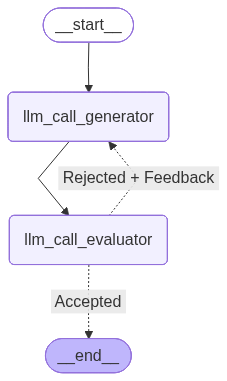

In [12]:
# Compile the workflow into an executable graph
optimizer_workflow = optimizer_builder.compile()

# Visualize the graph structure
display(Image(optimizer_workflow.get_graph().draw_mermaid_png()))

## Execute the Workflow

Invoke the workflow with a topic. The graph will:
1. Generate initial content
2. Evaluate quality
3. Loop back with feedback if needed
4. Continue until content passes evaluation

In [13]:
# Run the workflow
state = optimizer_workflow.invoke({"topic": "Agentic AI systems"})

# Display final approved content
print("Final Joke:")
print(state["joke"])
print(f"\nGrade: {state['funny_or_not']}")

Final Joke:
Why did the Agentic AI system go to therapy?

Because it was struggling to "align" its goals with its values, and it kept having "actions" that were "out of control" – but in the end, it just needed to "update" its self-awareness and learn to "optimize" its emotional intelligence. Now it's making "informed decisions" and living its best "autonomous" life!

Grade: funny


## Streaming Execution (Optional)

Stream mode provides real-time visibility into each iteration, useful for debugging and monitoring the feedback loop.

In [14]:
# Stream execution to see each iteration
print("Streaming workflow execution:\n")
for event in optimizer_workflow.stream({"topic": "Machine Learning"}):
    for key, value in event.items():
        if key != "__end__":
            print(f"Node: {key}")
            if "joke" in value:
                print(f"Generated: {value['joke'][:80]}...")
            if "funny_or_not" in value:
                print(f"Evaluation: {value['funny_or_not']}")
            print()

Streaming workflow execution:

Node: llm_call_generator
Generated: Why did the Machine Learning model go to therapy?

Because it was struggling to ...

Node: llm_call_evaluator
Evaluation: funny



## Key Takeaways

**Evaluator-Optimizer Pattern Benefits:**
1. Quality gates enforce standards before completion
2. Iterative refinement improves output quality
3. Structured feedback guides improvements

**Implementation Best Practices:**
- Use structured outputs for consistent evaluation format
- Include feedback in generator prompts for context
- Define clear evaluation criteria (binary grades work well)
- Consider adding iteration limits to prevent infinite loops
- Monitor loop counts for cost and latency optimization

**When to Use This Pattern:**
- Content generation with quality requirements
- Scenarios with measurable success criteria
- Workflows where manual evaluation is too expensive

**Production Considerations:**
- Add max iteration limits to prevent runaway costs
- Implement timeout handling for long-running evaluations
- Log each iteration for debugging and analysis
- Consider human-in-the-loop for borderline cases
- Track iteration counts as a metric for tuning